In [42]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l1

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# mobilenet

In [33]:

# Define paths to the training directories
good_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good"
ng_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng"

# Get the file names and construct the DataFrame
good_files = os.listdir(good_dir)
ng_files = os.listdir(ng_dir)

good_df = pd.DataFrame({"filename": good_files, "label": "0"})
good_df["filename"] = good_df["filename"].apply(lambda x: os.path.join(good_dir, x))

ng_df = pd.DataFrame({"filename": ng_files, "label": "1"})
ng_df["filename"] = ng_df["filename"].apply(lambda x: os.path.join(ng_dir, x))
data_df = pd.concat([good_df, ng_df], axis=0).reset_index(drop=True)


# Split the DataFrame into train and test DataFrames
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df["label"])

# Image dimensions
img_width, img_height = 223, 223

# Load the pre-trained MobileNet model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

##### Original
# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)



# Unfreeze the top layers of the MobileNet model
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Compile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Create ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col="filename", y_col="label", target_size=(img_width, img_height), batch_size=16, class_mode="binary")
test_generator = test_datagen.flow_from_dataframe(test_df, x_col="filename", y_col="label", target_size=(img_width, img_height), batch_size=16, class_mode="binary")

# Create the EarlyStopping callback with a patience value
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model
history = model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=[early_stopping])


Found 332 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 108 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 25 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/30
21/21 [==============================] - 28s 509ms/step - loss: 0.4444 - accuracy: 0.8102 - val_loss: 2.0521 - val_accuracy: 0.2588
Epoch 2/30
21/21 [==============================] - 8s 388ms/step - loss: 0.1000 - accuracy: 0.9910 - val_loss: 3.5732 - val_accuracy: 0.2588
Epoch 3/30
21/21 [==============================] - 9s 449ms/step - loss: 0.0461 - accuracy: 0.9970 - val_loss: 3.8756 - val_accuracy: 0.2588
Epoch 4/30
21/21 [==============================] - 9s 447ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 3.4194 - val_accuracy: 0.2588
Epoch 5/30
21/21 [==============================] - 8s 392ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 2.9761 - val_accuracy: 0.2588
Epoch 6/30
21/21 [==============================] - 10s 462ms/step - loss: 0.0189 - accuracy: 0.9910 - val_loss: 1.5715 - val_accuracy: 0.3529
Epoch 7/30
21/21 [==============================] - 10s 462ms/step - loss: 0.0434 - accuracy: 0.9819 - val_loss: 0.9946 - val_accuracy: 0.5294
Epo

# Efficientnet

In [43]:
# Define paths to the training directories
good_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good"
ng_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/ng"

# Get the file names and construct the DataFrame
good_files = os.listdir(good_dir)
ng_files = os.listdir(ng_dir)

good_df = pd.DataFrame({"filename": good_files, "label": "0"})
good_df["filename"] = good_df["filename"].apply(lambda x: os.path.join(good_dir, x))

ng_df = pd.DataFrame({"filename": ng_files, "label": "1"})
ng_df["filename"] = ng_df["filename"].apply(lambda x: os.path.join(ng_dir, x))
data_df = pd.concat([good_df, ng_df], axis=0).reset_index(drop=True)

# Split the DataFrame into train and test DataFrames
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df["label"])

# Image dimensions
img_width, img_height = 223, 223

# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
x = Dense(64, activation='relu', kernel_regularizer=l1(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Create ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col="filename", y_col="label", target_size=(img_width, img_height), batch_size=16, class_mode="binary")
test_generator = test_datagen.flow_from_dataframe(test_df, x_col="filename", y_col="label", target_size=(img_width, img_height), batch_size=16, class_mode="binary")

# Create the EarlyStopping callback with a patience value
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Found 332 validated image filenames belonging to 2 classes.
Found 85 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 108 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 25 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/30
21/21 [==============================] - 58s 597ms/step - loss: 6.7094 - accuracy: 0.5331 - val_loss: 6.7106 - val_accuracy: 0.2588
Epoch 2/30
21/21 [==============================] - 11s 517ms/step - loss: 6.4276 - accuracy: 0.7651 - val_loss: 6.6233 - val_accuracy: 0.2588
Epoch 3/30
21/21 [==============================] - 11s 493ms/step - loss: 6.1903 - accuracy: 0.8193 - val_loss: 6.4504 - val_accuracy: 0.2588
Epoch 4/30
21/21 [==============================] - 11s 518ms/step - loss: 5.9425 - accuracy: 0.8916 - val_loss: 6.2704 - val_accuracy: 0.2588
Epoch 5/30
21/21 [==============================] - 11s 503ms/step - loss: 5.6972 - accuracy: 0.9367 - val_loss: 6.1144 - val_accuracy: 0.2588
Epoch 6/30
21/21 [==============================] - 10s 459ms/step - loss: 5.4870 - accuracy: 0.9608 - val_loss: 5.9674 - val_accuracy: 0.2588
Epoch 7/30
21/21 [==============================] - 10s 467ms/step - loss: 5.2664 - accuracy: 0.9880 - val_loss: 5.8382 - val_accuracy: 0.2588

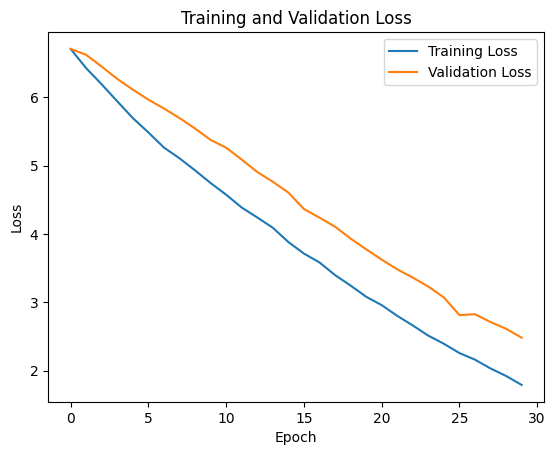

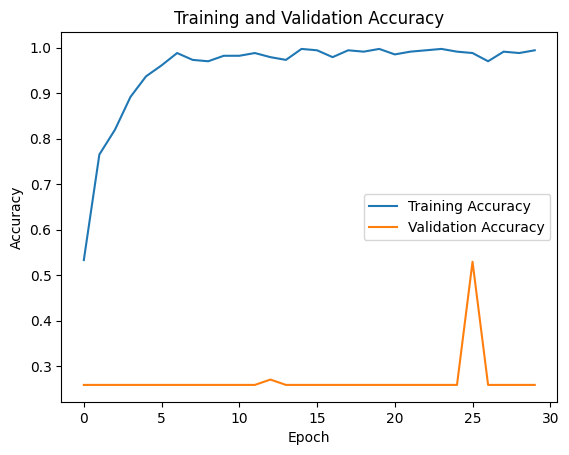

In [44]:
# Plot the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the trained model
model.save("foreign_object_classifier_finetuned_mobilenet.h5")

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model("foreign_object_classifier_finetuned_mobilenet.h5")


In [4]:
# Load an X-ray image of the food production line
xray_image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good/Snap-0185.jpg")

# Resize the image to the expected input dimensions
resized_image = cv2.resize(xray_image, (img_width, img_height))

# Convert the resized image to a NumPy array and normalize pixel values
image_array = np.array(resized_image) / 255.0

# Expand the dimensions of the image array to match the model input shape
image_array_expanded = np.expand_dims(image_array, axis=0)

# Predict the class of the image (0 = foreign object, 1 = no foreign object)
prediction = model.predict(image_array_expanded)

# If the prediction is closer to 0, then there is a foreign object
print(prediction)
if prediction < 0.5:
    print("Foreign object detected!")
else:
    print("No foreign object detected.")

1/1 [==============================] - 1s 688ms/step
[[0.00887226]]
Foreign object detected!


In [8]:
import os
import pandas as pd
import cv2
import numpy as np

# Define the path to the evaluation images
eval_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img/good"

# Get the file names from the evaluation directory
eval_files = os.listdir(eval_dir)

# Create an empty list to store the evaluation results
eval_results = []

for file in eval_files:
    # Load the image
    image = cv2.imread(os.path.join(eval_dir, file))

    # Check if the image is valid
    if image is not None:
        # Resize the image to the expected input dimensions
        resized_image = cv2.resize(image, (img_width, img_height))

        # Convert the resized image to a NumPy array and normalize pixel values
        image_array = np.array(resized_image) / 255.0

        # Expand the dimensions of the image array to match the model input shape
        image_array_expanded = np.expand_dims(image_array, axis=0)

        # Predict the class of the image (0 = foreign object, 1 = no foreign object)
        prediction = model.predict(image_array_expanded)

        # Determine the judgment result for the foreign object
        judgment = "Foreign object detected" if prediction[0][0] < 0.5 else "No foreign object detected"

        # Add the image path, prediction result, and judgment result to the list
        eval_results.append([os.path.join(eval_dir, file), prediction[0][0], judgment])
    else:
        print(f"Invalid image file: {os.path.join(eval_dir, file)}")

# Convert the list of results to a DataFrame
eval_df = pd.DataFrame(eval_results, columns=["image_path", "prediction", "judgment"])





1/1 [==============================] - 0s 24ms/step


In [13]:
eval_df['judgment'].value_counts()

Foreign object detected    110
Name: judgment, dtype: int64

In [45]:
import os
import pandas as pd
import cv2
import numpy as np

# Define the path to the evaluation images
eval_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/anomaly"

# Get the file names from the evaluation directory
eval_files = os.listdir(eval_dir)

# Create an empty list to store the evaluation results
eval_results = []

for file in eval_files:
    # Load the image
    image = cv2.imread(os.path.join(eval_dir, file))

    # Check if the image is valid
    if image is not None:
        # Resize the image to the expected input dimensions
        resized_image = cv2.resize(image, (img_width, img_height))

        # Convert the resized image to a NumPy array and normalize pixel values
        image_array = np.array(resized_image) / 255.0

        # Expand the dimensions of the image array to match the model input shape
        image_array_expanded = np.expand_dims(image_array, axis=0)

        # Predict the class of the image (0 = foreign object, 1 = no foreign object)
        prediction = model.predict(image_array_expanded)

        # Determine the judgment result for the foreign object
        # judgment = "Foreign object detected" if prediction[0][0] < 0.5 else "No foreign object detected"
        judgment = "No foreign object detected" if prediction[0][0] < 0.5 else "!!!foreign object detected!!!"

        # Add the image path, prediction result, and judgment result to the list
        eval_results.append([os.path.join(eval_dir, file), prediction[0][0], judgment])
    else:
        print(f"Invalid image file: {os.path.join(eval_dir, file)}")

# Convert the list of results to a DataFrame
eval_df = pd.DataFrame(eval_results, columns=["image_path", "prediction", "judgment"])





1/1 [==============================] - 0s 25ms/step


In [46]:
eval_df

,image_path,prediction,judgment
0,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.378643,No foreign object detected
1,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.398771,No foreign object detected
2,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.415631,No foreign object detected
3,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.359866,No foreign object detected
4,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.423627,No foreign object detected
5,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.424634,No foreign object detected
6,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.422092,No foreign object detected
7,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.444660,No foreign object detected
8,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.391237,No foreign object detected


In [35]:
import os
import pandas as pd
import cv2
import numpy as np

def evaluate_images(eval_dir, model, img_width, img_height):
    # Get the file names from the evaluation directory
    eval_files = os.listdir(eval_dir)

    # Create an empty list to store the evaluation results
    eval_results = []

    for file in eval_files:
        # Load the image
        image = cv2.imread(os.path.join(eval_dir, file))

        # Check if the image is valid
        if image is not None:
            # Resize the image to the expected input dimensions
            resized_image = cv2.resize(image, (img_width, img_height))

            # Convert the resized image to a NumPy array and normalize pixel values
            image_array = np.array(resized_image) / 255.0

            # Expand the dimensions of the image array to match the model input shape
            image_array_expanded = np.expand_dims(image_array, axis=0)

            # Predict the class of the image (0 = foreign object, 1 = no foreign object)
            prediction = model.predict(image_array_expanded)

            # Determine the judgment result for the foreign object
            judgment = "No foreign object detected" if prediction[0][0] < 0.5 else "!!!foreign object detected!!!"

            # Add the image path, prediction result, and judgment result to the list
            eval_results.append([os.path.join(eval_dir, file), prediction[0][0], judgment])
        else:
            print(f"Invalid image file: {os.path.join(eval_dir, file)}")

    # Convert the list of results to a DataFrame
    eval_df = pd.DataFrame(eval_results, columns=["image_path", "prediction", "judgment"])
    
    return eval_df

In [36]:
# Example usage
eval_dir = "/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/anomaly"
eval_df = evaluate_images(eval_dir, model, img_width, img_height)


1/1 [==============================] - 0s 25ms/step


In [38]:

eval_df['judgment'].value_counts()


!!!foreign object detected!!!    5
No foreign object detected       4
Name: judgment, dtype: int64

In [39]:
eval_df

,image_path,prediction,judgment
0,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.000012,No foreign object detected
1,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.000014,No foreign object detected
2,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.000080,No foreign object detected
3,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.000264,No foreign object detected
4,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.999999,!!!foreign object detected!!!
5,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.999995,!!!foreign object detected!!!
6,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.999999,!!!foreign object detected!!!
7,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.999996,!!!foreign object detected!!!
8,/content/drive/MyDrive/Colab Notebooks/10.cj_p...,0.999920,!!!foreign object detected!!!
